# An√°lise do Efeito Fotoel√©trico

An√°lise experimental dos dados do efeito fotoel√©trico para determina√ß√£o da constante de Planck (h) e fun√ß√£o trabalho (œÜ).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

# Configura√ß√µes para alta qualidade
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 8

## 1. Carregamento e Prepara√ß√£o dos Dados

In [4]:
# Carregar dados de potencial de freamento (diferentes aberturas)
df_potenciais = pd.read_csv('dados_variacao_intensidade.csv', decimal=',')
df_potenciais.columns = df_potenciais.columns.str.strip()

# Converter colunas para num√©rico
for col in df_potenciais.columns[1:]:
    df_potenciais[col] = pd.to_numeric(df_potenciais[col], errors='coerce')

print("Dados de Potencial de Freamento:")
print(df_potenciais)
print(f"\nComprimentos de onda dispon√≠veis: {df_potenciais['Œª (nm)'].values} nm")

Dados de Potencial de Freamento:
   Œª (nm)  tens√£o (V) abertura 8  tens√£o abertura 4  Tens√£o abertura 2
0     365                 -1.706             -1.667             -1.510
1     405                 -1.263             -1.190             -0.978
2     436                 -1.080             -1.036             -0.884
3     546                 -0.597             -0.587             -0.502
4     577                 -0.488             -0.474             -0.403

Comprimentos de onda dispon√≠veis: [365 405 436 546 577] nm


In [5]:
# Carregar dados de varia√ß√£o de tens√£o (curvas I-V completas)
df_curvas = pd.read_csv('dados_variacao_tensao.csv', decimal=',')
df_curvas.columns = df_curvas.columns.str.strip()

# Processar coluna de corrente considerando a escala 10^-12 A
def processar_corrente(row):
    corrente_str = str(row['Corrente (A)']).replace(',', '.')
    corrente = float(corrente_str)
    escala = str(row['Escala'])
    
    if '10^-12' in escala:
        return corrente * 1e-12
    elif '10^-11' in escala:
        return corrente * 1e-11
    elif '10^-10' in escala:
        return corrente * 1e-10
    return corrente

# Garantir convers√£o correta da tens√£o (v√≠rgula j√° convertida pelo decimal=',')
df_curvas['Tens√£o (V)'] = df_curvas['Tens√£o (V)']
df_curvas['Corrente_Real (A)'] = df_curvas.apply(processar_corrente, axis=1)

print(f"\nTotal de medi√ß√µes de corrente vs tens√£o: {len(df_curvas)}")
print(f"Comprimentos de onda medidos: {df_curvas['Œª (nm)'].unique()}")
print(f"Aberturas utilizadas: {df_curvas['Abertura (mm)'].unique()}")
print(f"\nExemplo de valores de tens√£o:")
print(df_curvas[['Œª (nm)', 'Abertura (mm)', 'Tens√£o (V)', 'Corrente_Real (A)']].head(10))


Total de medi√ß√µes de corrente vs tens√£o: 189
Comprimentos de onda medidos: [365 405 436]
Aberturas utilizadas: ['8mm' '4mm' '2mm']

Exemplo de valores de tens√£o:
   Œª (nm) Abertura (mm)  Tens√£o (V)  Corrente_Real (A)
0     365           8mm      -1.756       0.000000e+00
1     365           8mm      -1.581       1.420000e-10
2     365           8mm      -1.406       3.750000e-10
3     365           8mm      -1.231       6.610000e-10
4     365           8mm      -1.056       9.840000e-10
5     365           8mm      -0.881       1.290000e-09
6     365           8mm      -0.706       1.640000e-09
7     365           8mm      -0.531       2.010000e-09
8     365           8mm      -0.356       2.410000e-09
9     365           8mm      -0.180       2.770000e-09


## 2. Gr√°fico I: Curvas Corrente vs Tens√£o (Diferentes Intensidades)

Este gr√°fico mostra como a fotocorrente varia com a tens√£o aplicada para diferentes intensidades luminosas (aberturas diferentes). √â um dos gr√°ficos mais importantes do efeito fotoel√©trico, demonstrando que o potencial de freamento n√£o depende da intensidade.

C:\Users\Filipe\AppData\Local\Temp\ipykernel_29068\779064173.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


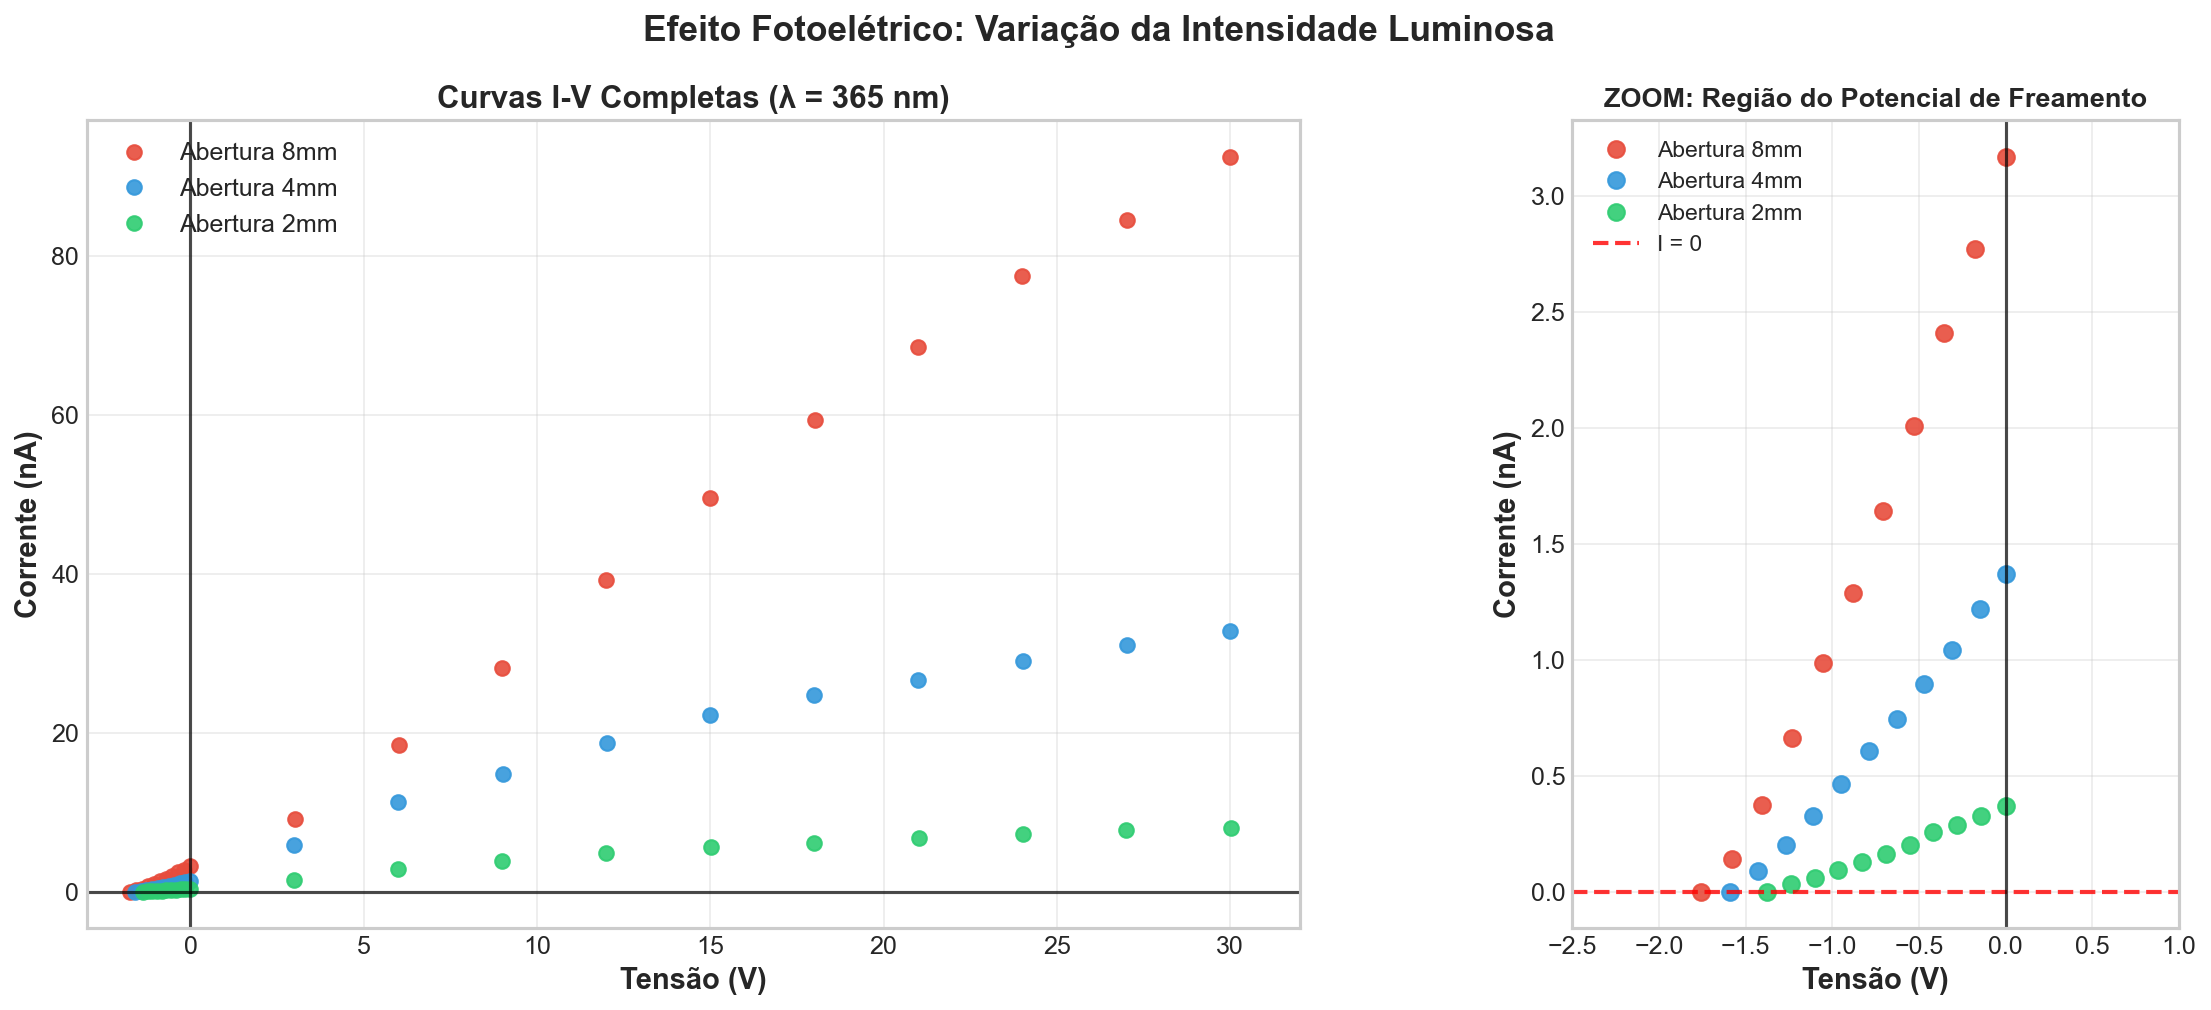


üìä Observa√ß√£o importante: No zoom, vemos que as tr√™s curvas cruzam I=0
aproximadamente no mesmo ponto (V‚ÇÄ ‚âà -1.7V), independente da intensidade!
Isso confirma que o potencial de freamento depende apenas da frequ√™ncia.


In [6]:
# Gr√°fico de I vs V para diferentes intensidades (Œª = 365 nm) com ZOOM
lambda_365 = df_curvas[df_curvas['Œª (nm)'] == 365]
aberturas = lambda_365['Abertura (mm)'].unique()
cores = ['#e74c3c', '#3498db', '#2ecc71']

fig = plt.figure(figsize=(18, 7))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.3)

# Gr√°fico principal
ax1 = fig.add_subplot(gs[0])

for abertura, cor in zip(sorted(aberturas, reverse=True), cores):
    dados = lambda_365[lambda_365['Abertura (mm)'] == abertura]
    dados_limpos = dados.dropna(subset=['Tens√£o (V)', 'Corrente_Real (A)'])
    ax1.plot(dados_limpos['Tens√£o (V)'], dados_limpos['Corrente_Real (A)'] * 1e9, 
            'o', label=f'Abertura {abertura}', color=cor, markersize=7, alpha=0.9)

ax1.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
ax1.set_xlabel('Tens√£o (V)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Corrente (nA)', fontsize=14, fontweight='bold')
ax1.set_title('Curvas I-V Completas (Œª = 365 nm)', fontsize=15, fontweight='bold')
ax1.legend(fontsize=12, loc='upper left', framealpha=0.95)
ax1.grid(True, alpha=0.4)
ax1.set_xlim(-3, 32)

# ZOOM na regi√£o do potencial de freamento
ax2 = fig.add_subplot(gs[1])

for abertura, cor in zip(sorted(aberturas, reverse=True), cores):
    dados = lambda_365[lambda_365['Abertura (mm)'] == abertura]
    dados_limpos = dados.dropna(subset=['Tens√£o (V)', 'Corrente_Real (A)'])
    # Filtrar regi√£o pr√≥xima ao zero
    dados_zoom = dados_limpos[(dados_limpos['Tens√£o (V)'] >= -2.5) & (dados_limpos['Tens√£o (V)'] <= 1)]
    ax2.plot(dados_zoom['Tens√£o (V)'], dados_zoom['Corrente_Real (A)'] * 1e9, 
            'o', label=f'Abertura {abertura}', color=cor, markersize=8, alpha=0.9)

ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='I = 0')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('Tens√£o (V)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Corrente (nA)', fontsize=14, fontweight='bold')
ax2.set_title('ZOOM: Regi√£o do Potencial de Freamento', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11, framealpha=0.95)
ax2.grid(True, alpha=0.4)
ax2.set_xlim(-2.5, 1)

plt.suptitle('Efeito Fotoel√©trico: Varia√ß√£o da Intensidade Luminosa', 
             fontsize=17, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\nüìä Observa√ß√£o importante: No zoom, vemos que as tr√™s curvas cruzam I=0")
print("aproximadamente no mesmo ponto (V‚ÇÄ ‚âà -1.7V), independente da intensidade!")
print("Isso confirma que o potencial de freamento depende apenas da frequ√™ncia.")

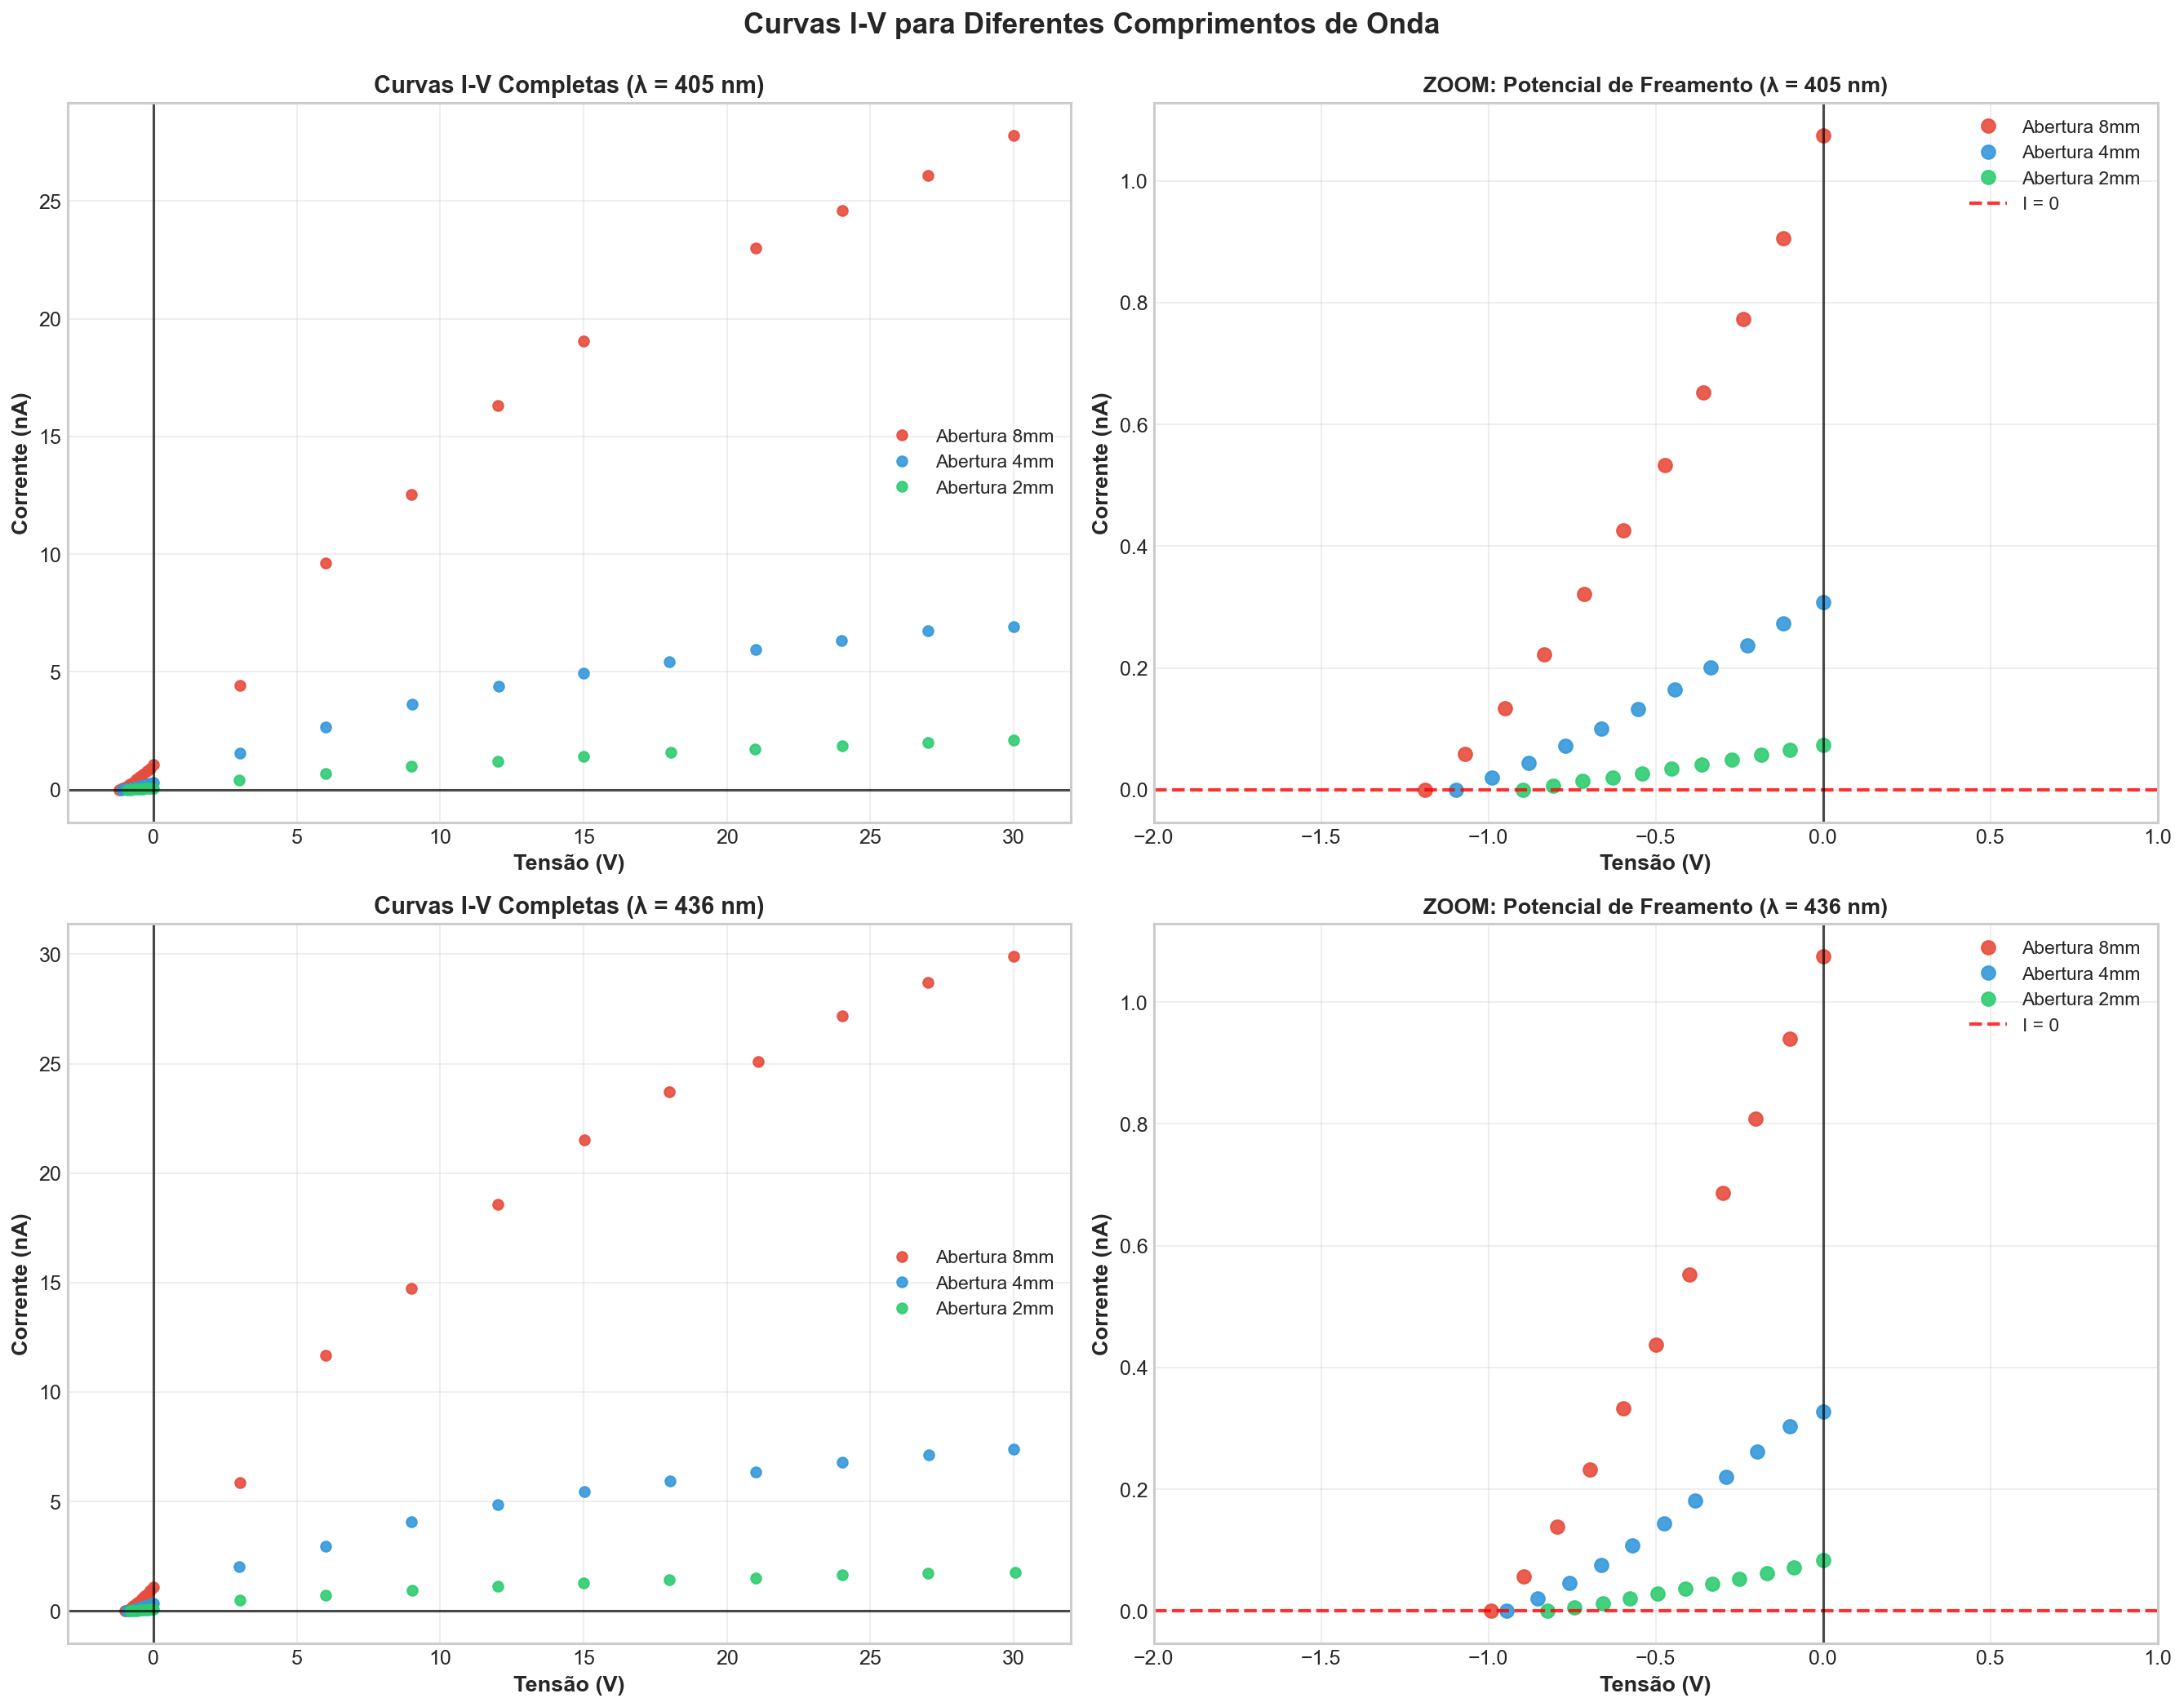

In [7]:
# Gr√°ficos para os outros comprimentos de onda COM ZOOM
lambdas_plot = [405, 436]
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

for idx, lambda_val in enumerate(lambdas_plot):
    dados_lambda = df_curvas[df_curvas['Œª (nm)'] == lambda_val]
    aberturas = dados_lambda['Abertura (mm)'].unique()
    
    # Gr√°fico completo
    ax_full = axes[idx, 0]
    for abertura, cor in zip(sorted(aberturas, reverse=True), cores):
        dados = dados_lambda[dados_lambda['Abertura (mm)'] == abertura]
        dados_limpos = dados.dropna(subset=['Tens√£o (V)', 'Corrente_Real (A)'])
        ax_full.plot(dados_limpos['Tens√£o (V)'], dados_limpos['Corrente_Real (A)'] * 1e9, 
                'o', label=f'Abertura {abertura}', color=cor, markersize=6, alpha=0.9)
    
    ax_full.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax_full.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax_full.set_xlabel('Tens√£o (V)', fontsize=13, fontweight='bold')
    ax_full.set_ylabel('Corrente (nA)', fontsize=13, fontweight='bold')
    ax_full.set_title(f'Curvas I-V Completas (Œª = {lambda_val} nm)', fontsize=14, fontweight='bold')
    ax_full.legend(fontsize=11, framealpha=0.95)
    ax_full.grid(True, alpha=0.4)
    ax_full.set_xlim(-3, 32)
    
    # ZOOM
    ax_zoom = axes[idx, 1]
    for abertura, cor in zip(sorted(aberturas, reverse=True), cores):
        dados = dados_lambda[dados_lambda['Abertura (mm)'] == abertura]
        dados_limpos = dados.dropna(subset=['Tens√£o (V)', 'Corrente_Real (A)'])
        dados_zoom = dados_limpos[(dados_limpos['Tens√£o (V)'] >= -2) & (dados_limpos['Tens√£o (V)'] <= 1)]
        ax_zoom.plot(dados_zoom['Tens√£o (V)'], dados_zoom['Corrente_Real (A)'] * 1e9, 
                'o', label=f'Abertura {abertura}', color=cor, markersize=8, alpha=0.9)
    
    ax_zoom.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='I = 0')
    ax_zoom.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax_zoom.set_xlabel('Tens√£o (V)', fontsize=13, fontweight='bold')
    ax_zoom.set_ylabel('Corrente (nA)', fontsize=13, fontweight='bold')
    ax_zoom.set_title(f'ZOOM: Potencial de Freamento (Œª = {lambda_val} nm)', fontsize=13, fontweight='bold')
    ax_zoom.legend(fontsize=11, framealpha=0.95)
    ax_zoom.grid(True, alpha=0.4)
    ax_zoom.set_xlim(-2, 1)

plt.suptitle('Curvas I-V para Diferentes Comprimentos de Onda', 
             fontsize=17, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 3. Determina√ß√£o dos Potenciais de Freamento

O potencial de freamento (V‚ÇÄ) √© a tens√£o m√≠nima necess√°ria para parar os fotoel√©trons mais energ√©ticos.

In [8]:
# Calcular m√©dia dos potenciais de freamento para cada comprimento de onda
potenciais_freamento = {}

for _, row in df_potenciais.iterrows():
    lambda_nm = row['Œª (nm)']
    tensoes = [abs(row['tens√£o (V) abertura 8']), 
               abs(row['tens√£o abertura 4']), 
               abs(row['Tens√£o abertura 2'])]
    potenciais_freamento[lambda_nm] = {
        'valores': tensoes,
        'media': np.mean(tensoes),
        'desvio': np.std(tensoes, ddof=1)
    }

print("\n" + "="*70)
print("POTENCIAIS DE FREAMENTO (V‚ÇÄ)")
print("="*70)
for lambda_nm, dados in potenciais_freamento.items():
    print(f"\nŒª = {lambda_nm} nm:")
    print(f"  Abertura 8mm: {dados['valores'][0]:.3f} V")
    print(f"  Abertura 4mm: {dados['valores'][1]:.3f} V")
    print(f"  Abertura 2mm: {dados['valores'][2]:.3f} V")
    print(f"  M√©dia: {dados['media']:.3f} ¬± {dados['desvio']:.3f} V")
print("="*70)


POTENCIAIS DE FREAMENTO (V‚ÇÄ)

Œª = 365.0 nm:
  Abertura 8mm: 1.706 V
  Abertura 4mm: 1.667 V
  Abertura 2mm: 1.510 V
  M√©dia: 1.628 ¬± 0.104 V

Œª = 405.0 nm:
  Abertura 8mm: 1.263 V
  Abertura 4mm: 1.190 V
  Abertura 2mm: 0.978 V
  M√©dia: 1.144 ¬± 0.148 V

Œª = 436.0 nm:
  Abertura 8mm: 1.080 V
  Abertura 4mm: 1.036 V
  Abertura 2mm: 0.884 V
  M√©dia: 1.000 ¬± 0.103 V

Œª = 546.0 nm:
  Abertura 8mm: 0.597 V
  Abertura 4mm: 0.587 V
  Abertura 2mm: 0.502 V
  M√©dia: 0.562 ¬± 0.052 V

Œª = 577.0 nm:
  Abertura 8mm: 0.488 V
  Abertura 4mm: 0.474 V
  Abertura 2mm: 0.403 V
  M√©dia: 0.455 ¬± 0.046 V


## 4. Gr√°fico II: Potencial de Freamento vs Frequ√™ncia (Equa√ß√£o de Einstein)

Este √© o gr√°fico mais importante para determinar a constante de Planck!

Segundo Einstein:
$$eV_0 = h\nu - \phi$$

ou seja:
$$V_0 = \frac{h}{e}\nu - \frac{\phi}{e}$$

Onde:
- **V‚ÇÄ**: potencial de freamento (V)
- **ŒΩ**: frequ√™ncia da luz (Hz)
- **h**: constante de Planck (J¬∑s)
- **œÜ**: fun√ß√£o trabalho do material (eV)
- **e**: carga do el√©tron (C)

A inclina√ß√£o da reta √© **h/e** e o intercepto √© **-œÜ/e**

In [9]:
# Converter comprimento de onda para frequ√™ncia
c = 2.998e8  # velocidade da luz (m/s)
e = 1.602e-19  # carga do el√©tron (C)

# Preparar dados para regress√£o COM M√âDIA
lambdas = np.array(list(potenciais_freamento.keys()))
frequencias = c / (lambdas * 1e-9)  # Hz
V0_medios = np.array([potenciais_freamento[l]['media'] for l in lambdas])
V0_erros = np.array([potenciais_freamento[l]['desvio'] for l in lambdas])

# Preparar dados SEM M√âDIA (apenas abertura 8mm)
V0_abertura8 = np.array([potenciais_freamento[l]['valores'][0] for l in lambdas])

# Regress√£o linear COM M√âDIA
slope, intercept, r_value, p_value, std_err = linregress(frequencias, V0_medios)

# Regress√£o linear SEM M√âDIA (abertura 8mm)
slope_8mm, intercept_8mm, r_value_8mm, p_value_8mm, std_err_8mm = linregress(frequencias, V0_abertura8)

# Calcular constante de Planck e fun√ß√£o trabalho
h_experimental = slope * e  # J¬∑s
phi_experimental = -intercept  # eV

h_experimental_8mm = slope_8mm * e  # J¬∑s
phi_experimental_8mm = -intercept_8mm  # eV

# Valores te√≥ricos
h_teorico = 6.626e-34  # J¬∑s
erro_percentual_h = abs(h_experimental - h_teorico) / h_teorico * 100
erro_percentual_h_8mm = abs(h_experimental_8mm - h_teorico) / h_teorico * 100

print("\n" + "="*70)
print("RESULTADOS DA REGRESS√ÉO LINEAR (COM M√âDIA)")
print("="*70)
print(f"\nEqua√ß√£o da reta: V‚ÇÄ = ({slope:.4e})¬∑ŒΩ + ({intercept:.4f})")
print(f"Coeficiente de correla√ß√£o (R¬≤): {r_value**2:.6f}")
print(f"\nüî¨ CONSTANTE DE PLANCK:")
print(f"   Experimental: h = {h_experimental:.4e} J¬∑s")
print(f"   Te√≥rico:      h = {h_teorico:.4e} J¬∑s")
print(f"   Erro:         {erro_percentual_h:.2f}%")
print(f"\n‚ö° FUN√á√ÉO TRABALHO:")
print(f"   œÜ = {phi_experimental:.3f} eV")

print("\n" + "="*70)
print("RESULTADOS DA REGRESS√ÉO LINEAR (ABERTURA 8mm)")
print("="*70)
print(f"\nEqua√ß√£o da reta: V‚ÇÄ = ({slope_8mm:.4e})¬∑ŒΩ + ({intercept_8mm:.4f})")
print(f"Coeficiente de correla√ß√£o (R¬≤): {r_value_8mm**2:.6f}")
print(f"\nüî¨ CONSTANTE DE PLANCK:")
print(f"   Experimental: h = {h_experimental_8mm:.4e} J¬∑s")
print(f"   Te√≥rico:      h = {h_teorico:.4e} J¬∑s")
print(f"   Erro:         {erro_percentual_h_8mm:.2f}%")
print(f"\n‚ö° FUN√á√ÉO TRABALHO:")
print(f"   œÜ = {phi_experimental_8mm:.3f} eV")
print(f"   (Material compat√≠vel com c√°todo de c√©sio ou liga de c√©sio-antim√¥nio)")
print("="*70)


RESULTADOS DA REGRESS√ÉO LINEAR (COM M√âDIA)

Equa√ß√£o da reta: V‚ÇÄ = (3.6609e-15)¬∑ŒΩ + (-1.4716)
Coeficiente de correla√ß√£o (R¬≤): 0.976830

üî¨ CONSTANTE DE PLANCK:
   Experimental: h = 5.8648e-34 J¬∑s
   Te√≥rico:      h = 6.6260e-34 J¬∑s
   Erro:         11.49%

‚ö° FUN√á√ÉO TRABALHO:
   œÜ = 1.472 eV

RESULTADOS DA REGRESS√ÉO LINEAR (ABERTURA 8mm)

Equa√ß√£o da reta: V‚ÇÄ = (3.8860e-15)¬∑ŒΩ + (-1.5518)
Coeficiente de correla√ß√£o (R¬≤): 0.989501

üî¨ CONSTANTE DE PLANCK:
   Experimental: h = 6.2253e-34 J¬∑s
   Te√≥rico:      h = 6.6260e-34 J¬∑s
   Erro:         6.05%

‚ö° FUN√á√ÉO TRABALHO:
   œÜ = 1.552 eV
   (Material compat√≠vel com c√°todo de c√©sio ou liga de c√©sio-antim√¥nio)


C:\Users\Filipe\AppData\Local\Temp\ipykernel_29068\1780943960.py:47: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()
c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


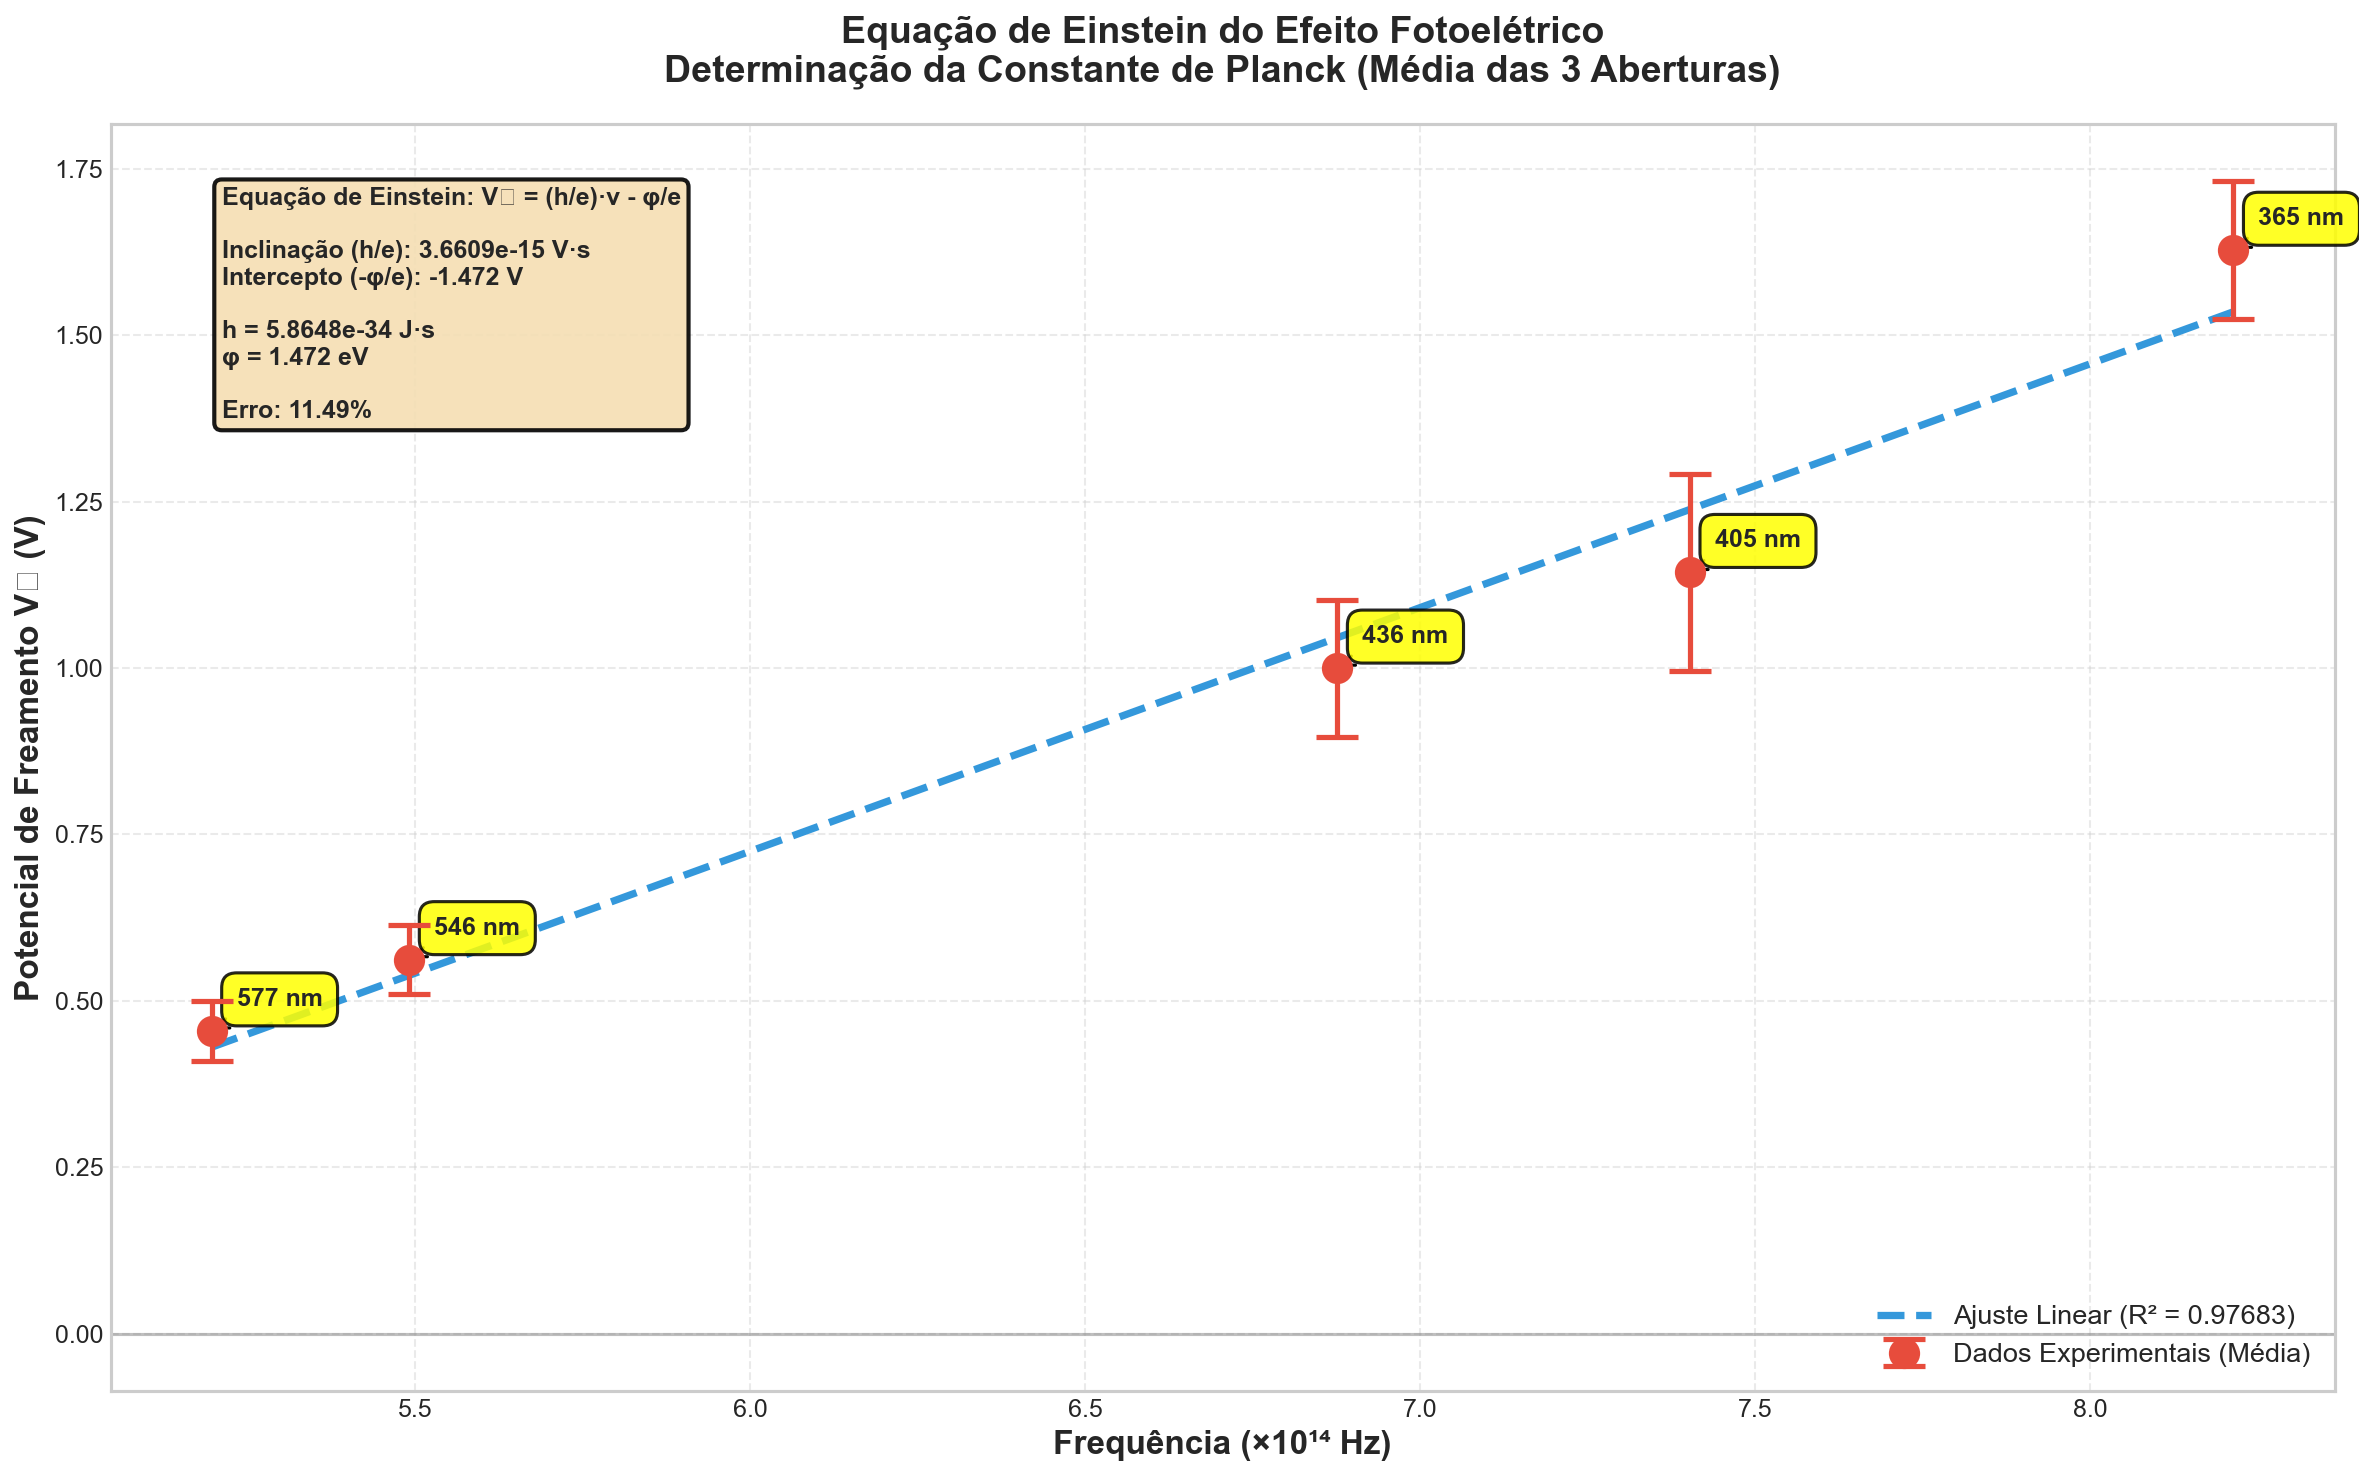

In [10]:
# Plotar V‚ÇÄ vs frequ√™ncia COM M√âDIA
fig, ax = plt.subplots(figsize=(16, 10))

# Dados experimentais com barras de erro
ax.errorbar(frequencias/1e14, V0_medios, yerr=V0_erros, 
            fmt='o', color='#e74c3c', markersize=14, capsize=10, capthick=2.5,
            linewidth=3, elinewidth=2.5, label='Dados Experimentais (M√©dia)', zorder=5)

# Reta de ajuste
freq_fit = np.linspace(frequencias.min(), frequencias.max(), 100)
V0_fit = slope * freq_fit + intercept
ax.plot(freq_fit/1e14, V0_fit, '--', color='#3498db', linewidth=3.5, 
        label=f'Ajuste Linear (R¬≤ = {r_value**2:.5f})', zorder=3)

# Linha horizontal no zero
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.5, zorder=1)

# Anota√ß√µes nos pontos
for i, (freq, V0, lamb) in enumerate(zip(frequencias/1e14, V0_medios, lambdas)):
    ax.annotate(f'{int(lamb)} nm', 
                xy=(freq, V0), xytext=(12, 12),
                textcoords='offset points', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.6', facecolor='yellow', alpha=0.85, edgecolor='black', linewidth=1.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1.5))

# Texto com resultados
texto_resultados = f"""Equa√ß√£o de Einstein: V‚ÇÄ = (h/e)¬∑ŒΩ - œÜ/e

Inclina√ß√£o (h/e): {slope:.4e} V¬∑s
Intercepto (-œÜ/e): {intercept:.3f} V

h = {h_experimental:.4e} J¬∑s
œÜ = {phi_experimental:.3f} eV

Erro: {erro_percentual_h:.2f}%"""

ax.text(0.05, 0.95, texto_resultados, transform=ax.transAxes,
        fontsize=12, verticalalignment='top', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=2))

ax.set_xlabel('Frequ√™ncia (√ó10¬π‚Å¥ Hz)', fontsize=16, fontweight='bold')
ax.set_ylabel('Potencial de Freamento V‚ÇÄ (V)', fontsize=16, fontweight='bold')
ax.set_title('Equa√ß√£o de Einstein do Efeito Fotoel√©trico\nDetermina√ß√£o da Constante de Planck (M√©dia das 3 Aberturas)', 
             fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=13, loc='lower right', framealpha=0.95, edgecolor='black', fancybox=True)
ax.grid(True, alpha=0.4, linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

C:\Users\Filipe\AppData\Local\Temp\ipykernel_29068\3008987685.py:46: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()


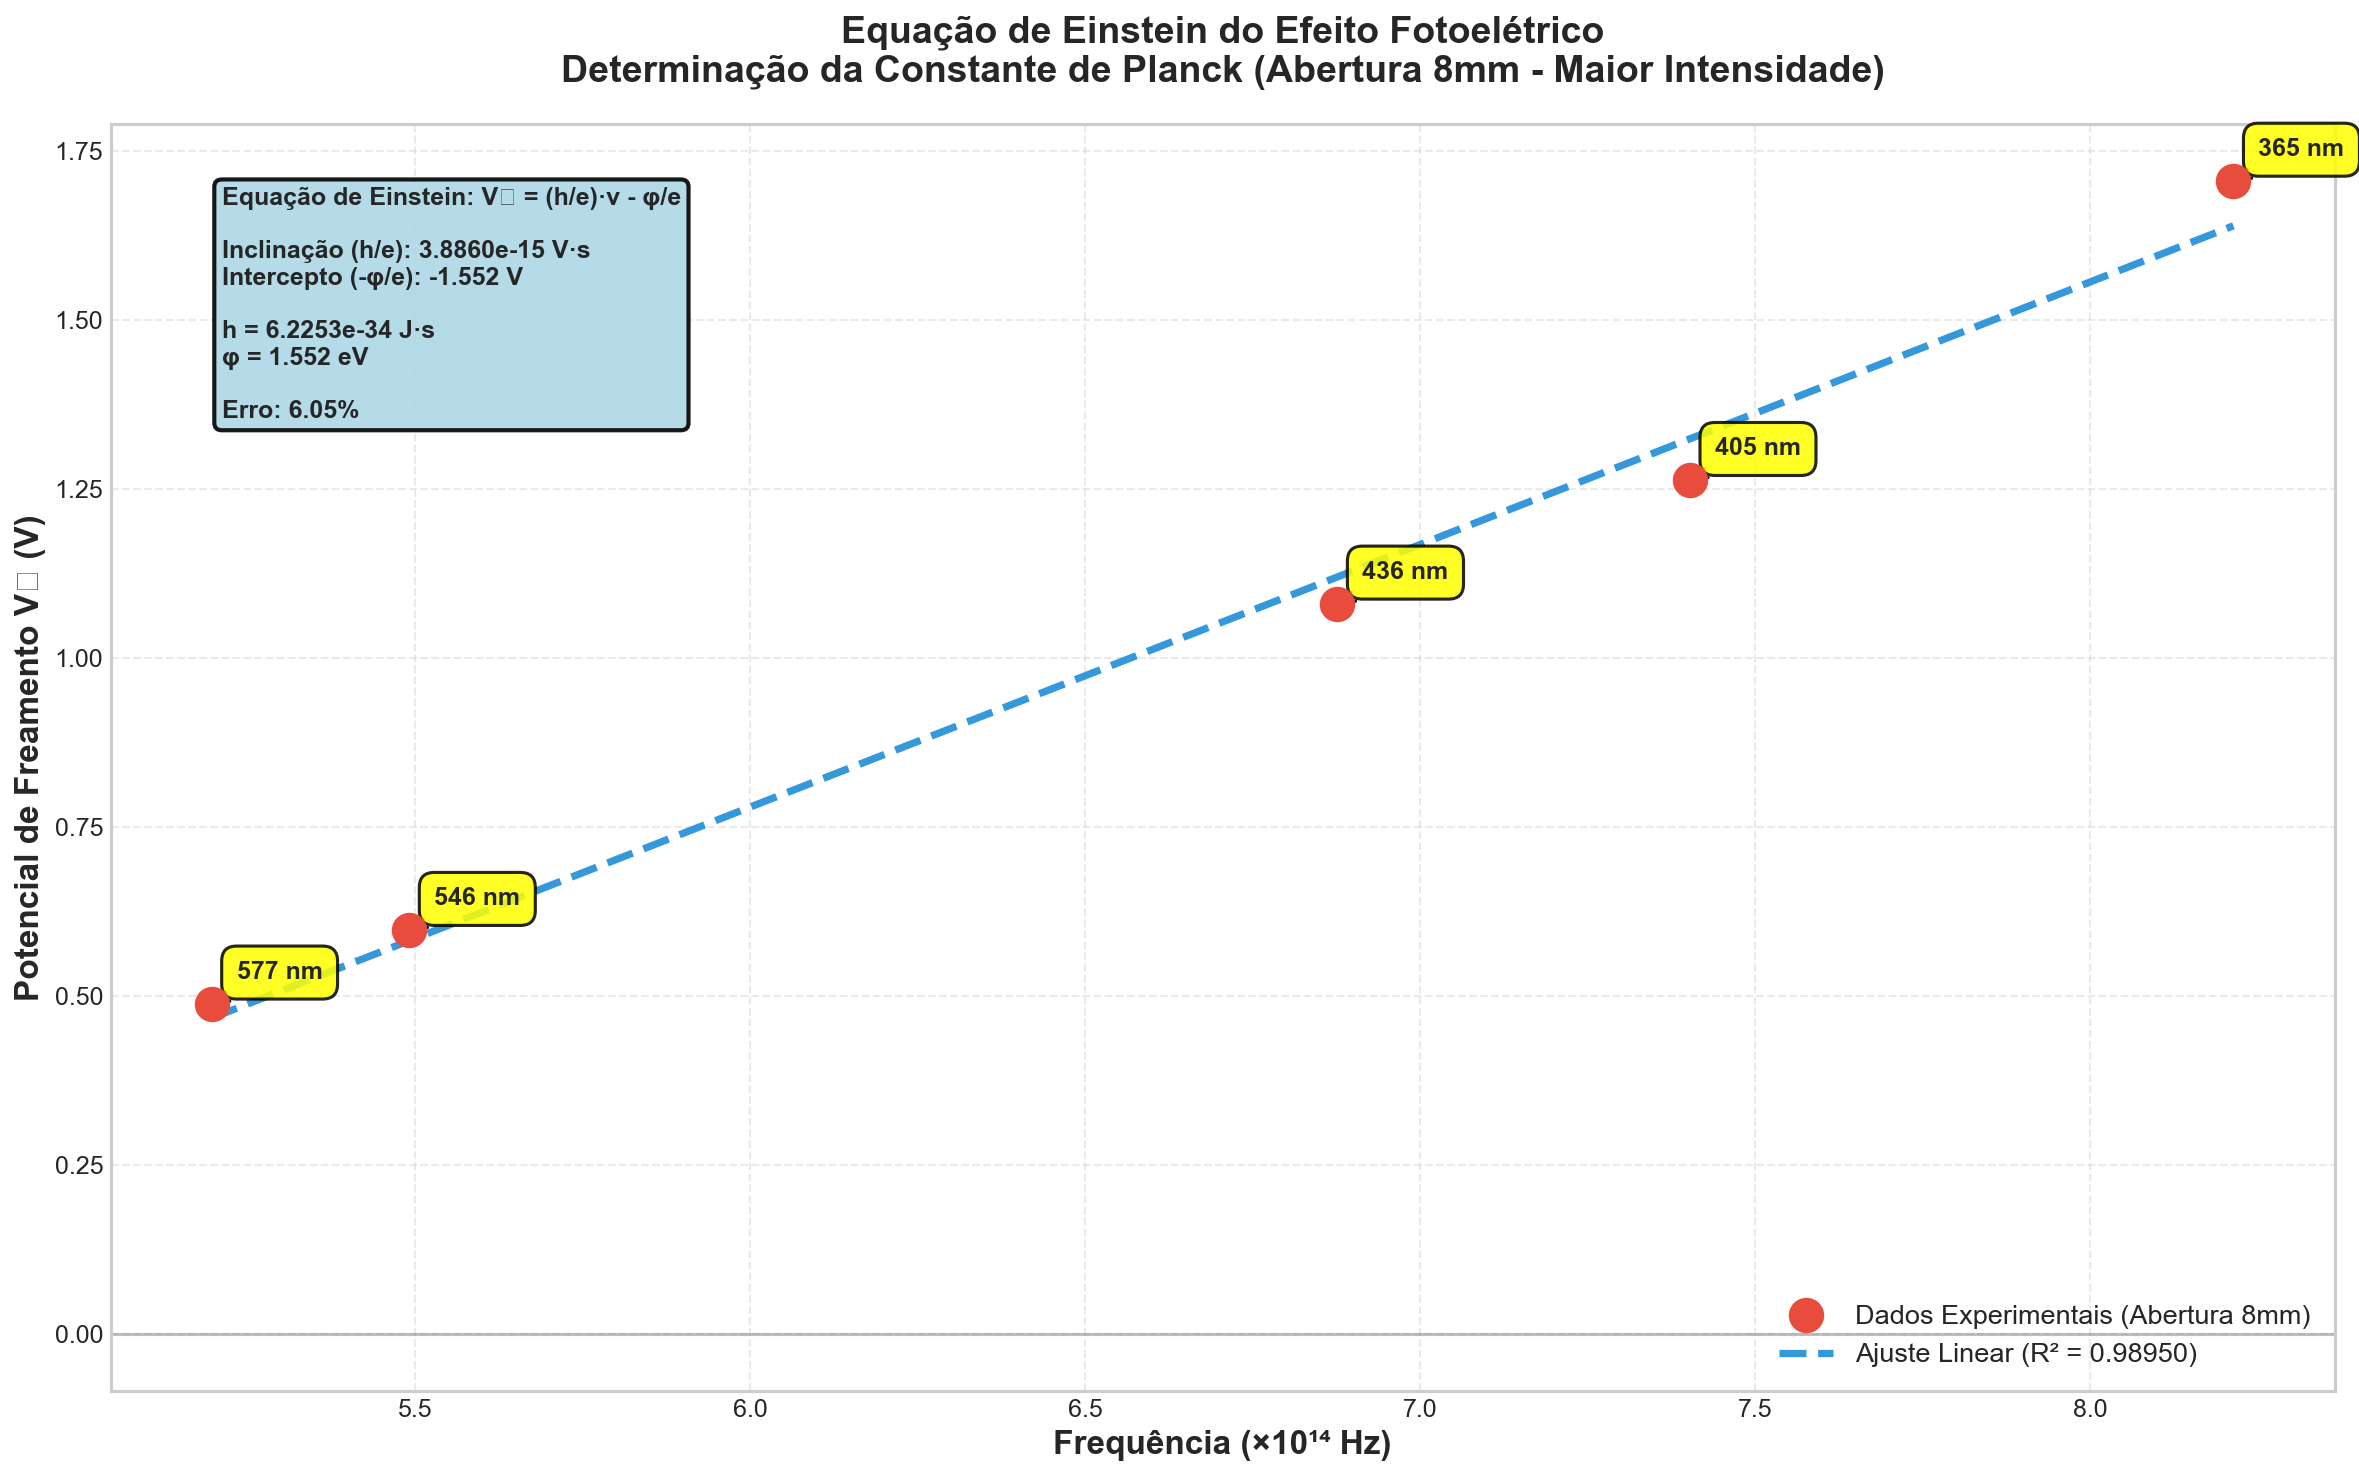

In [11]:
# Plotar V‚ÇÄ vs frequ√™ncia SEM M√âDIA (APENAS ABERTURA 8mm)
fig, ax = plt.subplots(figsize=(16, 10))

# Dados experimentais SEM barras de erro (abertura 8mm)
ax.plot(frequencias/1e14, V0_abertura8, 
        'o', color='#e74c3c', markersize=16, label='Dados Experimentais (Abertura 8mm)', zorder=5)

# Reta de ajuste
freq_fit = np.linspace(frequencias.min(), frequencias.max(), 100)
V0_fit_8mm = slope_8mm * freq_fit + intercept_8mm
ax.plot(freq_fit/1e14, V0_fit_8mm, '--', color='#3498db', linewidth=3.5, 
        label=f'Ajuste Linear (R¬≤ = {r_value_8mm**2:.5f})', zorder=3)

# Linha horizontal no zero
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.5, zorder=1)

# Anota√ß√µes nos pontos
for i, (freq, V0, lamb) in enumerate(zip(frequencias/1e14, V0_abertura8, lambdas)):
    ax.annotate(f'{int(lamb)} nm', 
                xy=(freq, V0), xytext=(12, 12),
                textcoords='offset points', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.6', facecolor='yellow', alpha=0.85, edgecolor='black', linewidth=1.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1.5))

# Texto com resultados
texto_resultados_8mm = f"""Equa√ß√£o de Einstein: V‚ÇÄ = (h/e)¬∑ŒΩ - œÜ/e

Inclina√ß√£o (h/e): {slope_8mm:.4e} V¬∑s
Intercepto (-œÜ/e): {intercept_8mm:.3f} V

h = {h_experimental_8mm:.4e} J¬∑s
œÜ = {phi_experimental_8mm:.3f} eV

Erro: {erro_percentual_h_8mm:.2f}%"""

ax.text(0.05, 0.95, texto_resultados_8mm, transform=ax.transAxes,
        fontsize=12, verticalalignment='top', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9, edgecolor='black', linewidth=2))

ax.set_xlabel('Frequ√™ncia (√ó10¬π‚Å¥ Hz)', fontsize=16, fontweight='bold')
ax.set_ylabel('Potencial de Freamento V‚ÇÄ (V)', fontsize=16, fontweight='bold')
ax.set_title('Equa√ß√£o de Einstein do Efeito Fotoel√©trico\nDetermina√ß√£o da Constante de Planck (Abertura 8mm - Maior Intensidade)', 
             fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=13, loc='lower right', framealpha=0.95, edgecolor='black', fancybox=True)
ax.grid(True, alpha=0.4, linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()